# Group Assignment - Data Collection
*by Grace*

## Topic
A machine learning model for predicting the mortality rate for stage II hypertension cohort

### Pipeline
0. **Research**
1. Data collection
  - Features (this should be decided through research)
    - Risk analysis (p value)
2. Data preprocessing
  - data balance
  - unification of measurement units
  - removing outliers
  - handling missing values
  - data normalization
3. Modeling - binary classifcation models
  - Training
  - Testing
  - Evaluations


# Digital Pheonotype

By [ncbi](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3704960/#:~:text=Stage%20II%20hypertension%20(systolic%20arterial,10%2C12%2C13%5D.):

| Hypertension Stage | Definition                                  | Notes/Consequences                                      |
|--------------------|---------------------------------------------|---------------------------------------------------------|
| Moderate (Stage I) | SAP ≥140 mmHg or DAP ≥90 mmHg               | Rarely treated in critically ill unless with symptoms.  |
| Stage II           | SAP >160 mmHg or DAP >100 mmHg              | Associated with acute cardiovascular complications. including acute heart failure, intensive care unit (ICU) admission, prolonged hospital stay, and death    |
| Severe             | SAP >180 mmHg and/or DAP >110 mmHg          | Defines severe hypertension.                            |

* SAP: systolic arterial pressure; DAP: diastolic arterial pressure

By [uptpdate](https://www.uptodate.com/contents/overview-of-hypertension-in-adults?search=hypertension&source=search_result&selectedTitle=1~150&usage_type=default&display_rank=1):


| Hypertension Type                   | Definition                                                                       |
|------------------------------------|----------------------------------------------------------------------------------|
| Stage 1                            | Systolic 130 to 139 mmHg or diastolic 80 to 89 mmHg                              |
| Stage 2                            | Systolic at least 140 mmHg or diastolic at least 90 mmHg                         |
| Isolated Systolic Hypertension     | Systolic ≥130 mmHg and diastolic <80 mmHg                                        |
| Isolated Diastolic Hypertension    | Systolic <130 mmHg and diastolic ≥80 mmHg                                        |
| Mixed Systolic/Diastolic           | Systolic ≥130 mmHg and diastolic ≥80 mmHg                                        |




In [2]:
# Import libraries

import os

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery
# authenticate
auth.authenticate_user()
# Set up environment variables
project_id = 'earnest-vine-395902'
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

dataset = 'mimiciv'


In [3]:
## check Module icu:
df = run_query("""
SELECT *
FROM `physionet-data.mimiciv_icu.d_items`
WHERE LOWER(label) LIKE '%systolic%' OR  LOWER(label) LIKE '%diastolic%';

""")
# 12  220050              Arterial Blood Pressure systolic
# 13  220051             Arterial Blood Pressure diastolic

# EDA

In [ ]:
query = f"""
WITH MortalityData AS (
    SELECT
        icu.subject_id,
        CASE WHEN pt.dod IS NOT NULL THEN 1 ELSE 0 END AS mortality
    FROM `physionet-data.mimiciv_icu.icustays` AS icu
    INNER JOIN `physionet-data.mimiciv_hosp.patients` AS pt
    ON icu.subject_id = pt.subject_id
    GROUP BY icu.subject_id, pt.dod
)

SELECT
    COUNT(DISTINCT subject_id) AS total_unique_icu_patients,
    SUM(mortality) AS total_deceased_patients,
    (SUM(mortality) * 100.0 / COUNT(DISTINCT subject_id)) AS mortality_rate_percent
FROM MortalityData
"""

pt3 = run_query(query)
pt3

,total_unique_icu_patients,total_deceased_patients,mortality_rate_percent
0,50920,16477,32.358602


In [ ]:
pt3

,total_unique_icu_patients,total_deceased_patients,mortality_rate_percent
0,50920,16477,32.358602


In [ ]:
query = f"""
WITH ICU_Admissions AS (
    SELECT
        subject_id,
        COUNT(*) AS num_admissions
    FROM `physionet-data.mimiciv_icu.icustays`
    GROUP BY subject_id
    HAVING num_admissions > 1
)
SELECT
    COUNT(DISTINCT subject_id) AS total_non_unique_icu_patients_with_single_stay
FROM ICU_Admissions

"""
pt = run_query(query)
pt # exclude 12448 patient who entered ICU more than once

,total_non_unique_icu_patients_with_single_stay
0,12448


In [ ]:
query = f"""
WITH Single_ICU_Admissions AS (
    SELECT
        subject_id,
        COUNT(*) AS num_admissions
    FROM `physionet-data.mimiciv_icu.icustays`
    GROUP BY subject_id
    HAVING num_admissions = 1
),

Short_ICU_Stays AS (
    SELECT
        subject_id
    FROM `physionet-data.mimiciv_icu.icustays`
    WHERE los <= 1
)

SELECT
    COUNT(DISTINCT a.subject_id) AS total_unique_icu_patients_single_stay_short_duration
FROM Single_ICU_Admissions a
JOIN Short_ICU_Stays b ON a.subject_id = b.subject_id

"""
pt = run_query(query)
pt # exclue 8182 short ICU stay patients (stayed less than 24 hours)

,total_unique_icu_patients_single_stay_short_duration
0,8182


## Digital Phenotype of Stage II hypotension

In [34]:
query = f"""
WITH Single_ICU_Stay AS (
    SELECT
        subject_id,
        COUNT(*) AS num_admissions,
        AVG(los) AS avg_los
    FROM `physionet-data.mimiciv_icu.icustays`
    GROUP BY subject_id
    HAVING num_admissions = 1
),

Filtered_ICU_Stay AS (
    SELECT
        subject_id
    FROM Single_ICU_Stay
    WHERE avg_los > 1
)

SELECT
    char.subject_id,
    COUNT(DISTINCT CASE WHEN (char.itemid = 220050 AND char.valuenum > 160) OR
                        (char.itemid = 220051 AND char.valuenum > 100) THEN char.subject_id END) AS hypertensive_patients,
    COUNT(DISTINCT CASE WHEN pt.dod IS NOT NULL THEN char.subject_id END) AS deceased_patients
FROM `physionet-data.mimiciv_icu.chartevents` AS char
INNER JOIN `physionet-data.mimiciv_hosp.patients` as pt ON char.subject_id = pt.subject_id
INNER JOIN Filtered_ICU_Stay AS fis ON char.subject_id = fis.subject_id
WHERE char.itemid IN (220050, 220051)
GROUP BY char.subject_id
"""
pt = run_query(query)
pt
print(f'{len(pt)} patient in total with "220050" and "220051" label')

14884 patient in total with "220050" and "220051" label


In [35]:
pt_hyper = pt[pt['hypertensive_patients'] ==1]
pt_hyper_mortality_rate = round(len(pt_hyper[pt_hyper['deceased_patients']==1])/len(pt[pt['hypertensive_patients'] ==1])*100, 2)
print(f'Among the {len(pt)} patients with label, {len(pt_hyper)} ({round(len(pt_hyper)/len(pt)*100,2)}%) satisfy stage 2 hypertension criteria')
print(f'Among the {len(pt_hyper)} stage 2 hypertension patients, {pt_hyper_mortality_rate}% deseased ')

Among the 14884 patients with label, 6186 (41.56%) satisfy stage 2 hypertension criteria
Among the 6186 stage 2 hypertension patients, 30.46% deseased 


In [36]:
pt_hyper

,subject_id,hypertensive_patients,deceased_patients
0,16797598,1,1
1,16605602,1,0
4,10037861,1,1
5,13187056,1,0
6,19259547,1,0
...,...,...,...
14791,12306709,1,1
14792,15708020,1,0
14818,19133838,1,0
14845,17987969,1,0


## Features (Risk Factors)
1. **Patients' Demographics**:
    - Tables: **`mimiciv_core.patients`** and **`mimiciv_core.admissions`**
    - Variables: **`Gender`**, **`Ethnicity`**, **`Age`**
2. **Clinical Measurements**:
    - Table: **`mimiciv_icu.chartevents`**
    - Variables: **`HR`**, **`SBP`**, **`DBP`**, **`RR`**, **`Temperature`**, **`SPO2`**, etc.
3. **Lab Measurements**:
    - Table: **`mimiciv_icu.labevents`**
    - Variables: **`INR`**, **`PT`**, **`APTT`**, **`WBC`**, **`RBC`**, **`Hemoglobin`**, etc.
4. **Scores**:
    - Possibly from the table: **`mimiciv_icu.oasis`**
    - Variables: **`APSIII`**, **`GCS`**

---


### 1. **Patients' Demographics**
- Tables: **`mimiciv_core.patients`** and **`mimiciv_core.admissions`**
- Variables: **`Gender`**, **`Ethnicity`**, **`Age`**

In [79]:
# Convert the 'subject_id' column to a list
subject_ids = pt_hyper['subject_id'].tolist()

# Convert the list to a comma-separated string
subject_ids_str = ', '.join(map(str, subject_ids))

# Use the formatted string in our SQL query
query = f"""
SELECT
    p.subject_id,
    p.gender,
    p.anchor_age
FROM
    `physionet-data.mimiciv_hosp.patients` AS p
WHERE
    p.subject_id IN ({subject_ids_str})

"""

demographic = run_query(query)
demographic

,subject_id,gender,anchor_age
0,10352416,M,23
1,10437328,F,23
2,10008454,F,26
3,11904515,M,26
4,18898128,M,30
...,...,...,...
6181,16931484,M,81
6182,13233264,M,55
6183,19815165,F,71
6184,13181161,F,85



### 2. **Clinical Measurements**:

  - Table: **`mimiciv_icu.chartevents`**
  - Variables: **`HR`**, **`SBP`**, **`DBP`**, **`RR`**, **`Temperature`**, **`SPO2`**, etc.

We found and will include that:

| Feature                            | ItemID |
|------------------------------------|--------|
| Heart rate (HR)                    | 220045 |
| Systolic blood pressure (SBP)      | 220050 |
| Diastolic blood pressure (DBP)     | 220051 |
| Respiratory rate (RR)              | 220210 |
| Heart rate Alarm - High            | 220046 |
| HrApacheIIScore                    | 226763 |
| RR > 35 for > 5 min                | 224718 |


In [ ]:
query = f"""
SELECT itemid, label
FROM `physionet-data.mimiciv_icu.d_items`
WHERE
    LOWER(label) LIKE 'heart rate%' OR
    LOWER(label) LIKE 'hr%' OR
    LOWER(label) LIKE '%blood pressure systolic' OR
    LOWER(label) LIKE '%blood pressure diastolic' OR
    LOWER(label) LIKE 'respiratory rate%' OR
    LOWER(label) LIKE 'rr%'
ORDER BY label;
"""

Clinical_Measurements = run_query(query)
Clinical_Measurements

,itemid,label
0,220051,Arterial Blood Pressure diastolic
1,220050,Arterial Blood Pressure systolic
2,224721,HR > 140
3,230037,HR per min
4,227018,HR_ApacheIV
5,220045,Heart Rate
6,220047,Heart Rate Alarm - Low
7,220046,Heart rate Alarm - High
8,226763,HrApacheIIScore
9,226764,HrApacheIIValue


### 3. **Lab Measurements**:

  - Table: **`mimiciv_icu.labevents`**

  - ariables: **`INR`**, **`PT`**, **`APTT`**, **`WBC`**, **`RBC`**, **`Hemoglobin`**, etc.

In [105]:
lab_items = [
    "Temperature",
    "PT",
    "RBC",
    "White Blood Cells",
    "Hemoglobin",
    "MCH",
    "MCHC",
    "RDW",
    "Anion Gap",
    "Creatinine",
    "Urea Nitrogen",
    "Calcium (ingr)",
    "Potassium, Whole Blood",
    "Sodium",
    "Chloride",
    "Bicarbonate",
    "Glucose"
]

print(lab_items)


['Temperature', 'PT', 'RBC', 'White Blood Cells', 'Hemoglobin', 'MCH', 'MCHC', 'RDW', 'Anion Gap', 'Creatinine', 'Urea Nitrogen', 'Calcium (ingr)', 'Potassium, Whole Blood', 'Sodium', 'Chloride', 'Bicarbonate', 'Glucose']


In [106]:
query = f"""
SELECT *
FROM physionet-data.mimiciv_hosp.d_labitems
"""
d_labitems = run_query(query)

In [107]:
d_labitems.to_csv('lab_items.csv')

In [108]:
#!pip install thefuzz
from thefuzz import process

# Find matches
matching_lab = {}
for word in lab_items:
    best_match, score = process.extractOne(word, list(d_labitems['label']))
    if score > 80:
        matching_lab[word] = best_match

print(matching_lab)

{'Temperature': 'Temperature', 'PT': 'PT', 'RBC': ' Rbc', 'White Blood Cells': 'White Blood Cells', 'Hemoglobin': 'Hemoglobin', 'MCH': 'MCH', 'MCHC': 'MCHC', 'RDW': 'RDW', 'Anion Gap': 'Anion Gap', 'Creatinine': 'Creatinine', 'Urea Nitrogen': 'Urea Nitrogen', 'Calcium (ingr)': 'Calcium Carbonate Crystals', 'Potassium, Whole Blood': 'Potassium, Whole Blood', 'Sodium': 'Sodium', 'Chloride': 'Chloride', 'Bicarbonate': 'Bicarbonate', 'Glucose': 'Glucose'}


In [109]:
matching_lab.values()

dict_values(['Temperature', 'PT', ' Rbc', 'White Blood Cells', 'Hemoglobin', 'MCH', 'MCHC', 'RDW', 'Anion Gap', 'Creatinine', 'Urea Nitrogen', 'Calcium Carbonate Crystals', 'Potassium, Whole Blood', 'Sodium', 'Chloride', 'Bicarbonate', 'Glucose'])

In [110]:
filtered_labitems = d_labitems[d_labitems['label'].isin(lab_items)]
filtered_labitems = filtered_labitems.drop_duplicates(subset='label', keep='first')

print(filtered_labitems)
labitems_ids = filtered_labitems['itemid'].tolist()
labitems_str = ', '.join(map(str, labitems_ids))


len(filtered_labitems)

      itemid                   label  fluid    category
12     50809                 Glucose  Blood   Blood Gas
14     50811              Hemoglobin  Blood   Blood Gas
25     50822  Potassium, Whole Blood  Blood   Blood Gas
28     50825             Temperature  Blood   Blood Gas
80     50868               Anion Gap  Blood   Chemistry
94     50882             Bicarbonate  Blood   Chemistry
114    50902                Chloride  Blood   Chemistry
124    50912              Creatinine  Blood   Chemistry
194    50983                  Sodium  Blood   Chemistry
216    51006           Urea Nitrogen  Blood   Chemistry
415    51755       White Blood Cells  Blood   Chemistry
967    51248                     MCH  Blood  Hematology
968    51249                    MCHC  Blood  Hematology
993    51274                      PT  Blood  Hematology
996    51277                     RDW  Blood  Hematology
1230   51493                     RBC  Urine  Hematology


16

In [111]:
labitems_str

'50809, 50811, 50822, 50825, 50868, 50882, 50902, 50912, 50983, 51006, 51755, 51248, 51249, 51274, 51277, 51493'

In [112]:
filtered_labitems.to_csv('filtered_labitems.csv')

In [121]:
labitems_ids = filtered_labitems['itemid'].tolist()
labitems_str = ', '.join(map(str, labitems_ids))
clinical_str = "220045, 220050, 220051, 220210, 220046, 226763, 224718"

In [180]:
query = f"""
WITH RankedEvents AS (
    SELECT
        le.subject_id AS subject_id,
        p.gender AS gender,
        p.anchor_age AS age,
        p.dod AS dod,
        l.itemid AS lab_itemid,
        l.label AS lab_label,
        le.valuenum AS lab_val,
        le.valueuom AS lab_unit,
        ROW_NUMBER() OVER(PARTITION BY le.subject_id, l.label ORDER BY le.itemid) AS rn
    FROM
        `physionet-data.mimiciv_hosp.labevents` AS le
    JOIN
        `physionet-data.mimiciv_hosp.d_labitems` AS l
        ON l.itemid = le.itemid

    JOIN
        `physionet-data.mimiciv_hosp.patients` AS p
        ON le.subject_id = p.subject_id
    WHERE le.itemid in ({labitems_str}) AND le.subject_id IN ({subject_ids_str})
    )

SELECT
    subject_id,
    gender,
    age,
    lab_label,
    lab_itemid,
    lab_val,
    lab_unit,
    dod
FROM
    RankedEvents
WHERE
    rn = 1
"""

lab_df = run_query(query)

lab_df.to_csv('lab_df.csv')

In [183]:
lab_df[lab_df['subject_id'] == 16233087]

,subject_id,gender,age,clinic_itemid,clinic_label,clinic_val,clinic_unit,dod
5016,16233087,M,71,220210,Respiratory Rate,12.0,insp/min,NaT
8777,16233087,M,71,220045,Heart Rate,72.0,bpm,NaT
15997,16233087,M,71,220046,Heart rate Alarm - High,120.0,bpm,NaT
20775,16233087,M,71,220050,Arterial Blood Pressure systolic,121.0,mmHg,NaT
27747,16233087,M,71,220051,Arterial Blood Pressure diastolic,50.0,mmHg,NaT


In [182]:
query = f"""
WITH RankedEvents AS (
    SELECT
        ce.subject_id AS subject_id,
        p.gender AS gender,
        p.anchor_age AS age,
        p.dod AS dod,
        c.itemid AS clinic_itemid,
        c.label AS clinic_label,
        ce.valuenum AS clinic_val,
        ce.valueuom AS clinic_unit,
        ROW_NUMBER() OVER(PARTITION BY ce.subject_id, c.label ORDER BY ce.itemid) AS rn
    FROM
        `physionet-data.mimiciv_icu.chartevents` AS ce
    JOIN
        `physionet-data.mimiciv_icu.d_items` AS c
        ON c.itemid = ce.itemid
    JOIN
        `physionet-data.mimiciv_hosp.patients` AS p
        ON ce.subject_id = p.subject_id
    WHERE ce.itemid in ({clinical_str}) AND
      ce.subject_id IN ({subject_ids_str})
    )

SELECT
    subject_id,
    gender,
    age,
    clinic_itemid,
    clinic_label,
    clinic_val,
    clinic_unit,
    dod
FROM
    RankedEvents
WHERE
    rn = 1
"""

clinic_df = run_query(query)

clinic_df.to_csv('clinic_df.csv')

In [158]:
clinic_df.subject_id.unique()

<IntegerArray>
[18539548, 19305113, 18770897, 10109956, 10214456, 10280054, 10516725,
 10624155, 10809326, 10835840,
 ...
 18267266, 18439312, 19549135, 19584607, 19620042, 19917565, 19993279,
 10103536, 14813765, 10180042]
Length: 6186, dtype: Int64

In [159]:
lab_df.subject_id.unique()

<IntegerArray>
[18487334, 16233087, 10353094, 10417271, 10655111, 10682684, 10704388,
 10927056, 11134420, 11326229,
 ...
 13233598, 14507421, 14836012, 15994613, 17048763, 17593758, 18630503,
 18795212, 19120138, 19898116]
Length: 6182, dtype: Int64

In [166]:
clinic_df.groupby('subject_id')

In [173]:
unique_label_counts = lab_df.groupby('subject_id')['lab_label'].nunique().reset_index()

# Rename the column to make it clear
unique_label_counts.columns = ['subject_id', 'unique_label_count']

# Display the table
print(unique_label_counts)

count_of_individuals = unique_label_counts['unique_label_count'].value_counts().reset_index()

# Rename the columns for clarity
count_of_individuals.columns = ['unique_label_count', 'count_of_individuals']

# Display the table
print(count_of_individuals)

      subject_id  unique_label_count
0       10002348                  11
1       10003046                  14
2       10004457                  15
3       10004606                  12
4       10005606                  13
...          ...                 ...
6177    19993726                  14
6178    19994505                  14
6179    19995595                  15
6180    19998843                  14
6181    19999442                  12

[6182 rows x 2 columns]
   unique_label_count  count_of_individuals
0                  14                  2190
1                  15                  1755
2                  13                  1060
3                  11                   471
4                  12                   463
5                  10                   239
6                   9                     3
7                  16                     1


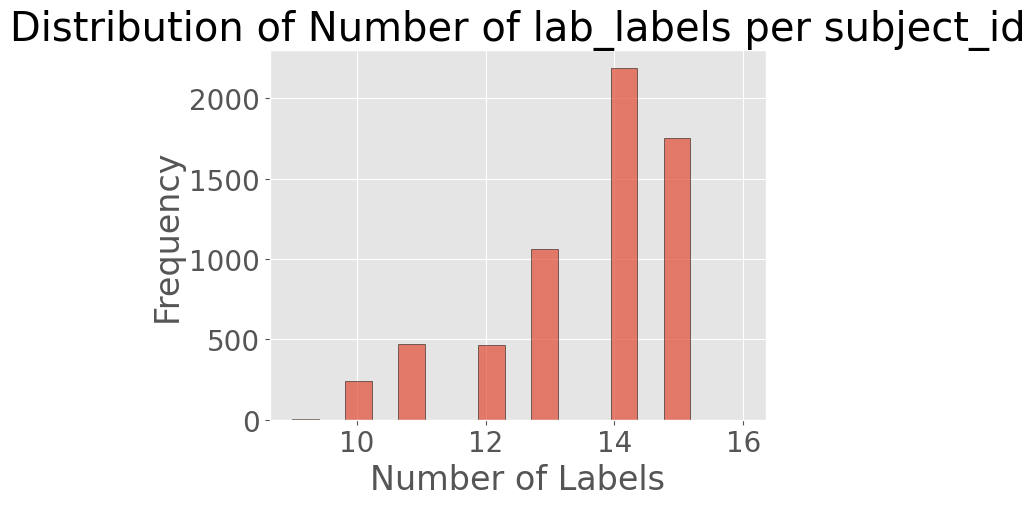

In [176]:
# Create a histogram to visualize the distribution of the number of labels
label_counts = lab_df['subject_id'].value_counts()
plt.hist(label_counts, bins=17, edgecolor='k', alpha=0.7)
plt.xlabel("Number of Labels")
plt.ylabel("Frequency")
plt.title("Distribution of Number of lab_labels per subject_id")
plt.show()

The above suggests that 3 hypertension 2 patiens have 9 labels; 239 patients has 10 labels, etc. We can see that the majority patients have more than 10 labels which suggest that our data can be good to train the model if we apply appropriate deletion, imputation methods etc.

1. **Understanding the Nature of Missingness**: Before deciding how to deal with the missing values, it's essential to understand why data might be missing. There are three main types of missing data:
   - **MCAR** (Missing Completely at Random): The missingness is not related to any other variable.
   - **MAR** (Missing at Random): The probability of missingness is related to some observed data but not the missing data itself.
   - **MNAR** (Missing Not at Random): The missingness is related to the missing data itself or some unobserved data.

2. **Deletion Methods**:
   - **Listwise Deletion (Complete Case Analysis)**: Exclude any case (or row) that has a missing value. This method is simple but can lead to loss of data, reducing statistical power.
   - **Pairwise Deletion**: Use all available data for each analysis. It maximizes the data available but can lead to inconsistency.

3. **Imputation Methods**:
   - **Mean/Median/Mode Imputation**: Replace missing values with the mean, median, or mode of the observed values. This can reduce variability and lead to underestimation of standard errors.
   - **Linear Regression Imputation**: Predict the missing value using a regression model.
   - **Multiple Imputation**: Multiple datasets are created, imputed, and analyzed. The results are then pooled to give estimates and confidence intervals.

4. **Advanced Methods**:
   - **Model-Based Methods**: Assumes that the data comes from a specific type of model, like Maximum Likelihood Estimation for normally distributed data.
   - **Machine Learning Methods**: Techniques like k-Nearest Neighbors can be used to predict and impute missing values.

5. **Sensitivity Analysis**: If we suspect that data might be MNAR, then a sensitivity analysis can help assess how sensitive our results are to the way we've handled the missing data.

Before deciding which method to use, consider the following:

- **Percentage of Missing Data**: If only a small percentage of data is missing for a risk factor, we might be able to justify dropping those patients from the analysis. However, if a large portion is missing, imputation or other methods might be preferable.
  
- **Nature of Missingness**: If missingness is related to the observed data (MAR), then imputation methods may be appropriate. If missingness is related to the unobserved data (MNAR), then the problem is more complex, and we might need to conduct sensitivity analyses.

- **Type of Data**: For categorical data, mode imputation or predictive modeling might be appropriate. For continuous data, mean or median imputation or regression imputation might be used.

- **Risk Factor Relationship**: If we believe that all the risk factors are essential and related to the outcome, then we should try to include all of them, addressing the missing data appropriately.

## EDA on filtered data

In [161]:
clinic_df

,subject_id,gender,age,clinic_itemid,clinic_label,clinic_val,clinic_unit
0,18539548,M,85,226763,HrApacheIIScore,0.0,None
1,19305113,M,51,226763,HrApacheIIScore,2.0,None
2,18770897,F,54,226763,HrApacheIIScore,3.0,None
3,10109956,F,62,220210,Respiratory Rate,28.0,insp/min
4,10214456,M,55,220210,Respiratory Rate,23.0,insp/min
...,...,...,...,...,...,...,...
30923,19502124,M,82,220051,Arterial Blood Pressure diastolic,44.0,mmHg
30924,19637282,F,80,220051,Arterial Blood Pressure diastolic,62.0,mmHg
30925,19655491,F,55,220051,Arterial Blood Pressure diastolic,55.0,mmHg
30926,19779215,F,86,220051,Arterial Blood Pressure diastolic,50.0,mmHg


In [162]:
lab_df

,subject_id,gender,age,lab_label,lab_itemid,lab_val,lab_unit
0,18487334,M,68,White Blood Cells,51755,6.8,K/uL
1,16233087,M,71,White Blood Cells,51755,10.5,K/uL
2,10353094,M,72,RBC,51493,NaN,#/hpf
3,10417271,M,80,RBC,51493,1.0,#/hpf
4,10655111,F,49,RBC,51493,2.0,#/hpf
...,...,...,...,...,...,...,...
83930,18214741,F,54,Creatinine,50912,0.7,mg/dL
83931,18457420,M,76,Creatinine,50912,1.1,mg/dL
83932,18808917,F,78,Creatinine,50912,0.5,mg/dL
83933,19752825,F,48,Creatinine,50912,0.8,mg/dL


In [163]:
lab_df

,subject_id,gender,age,lab_label,lab_itemid,lab_val,lab_unit
0,18487334,M,68,White Blood Cells,51755,6.8,K/uL
1,16233087,M,71,White Blood Cells,51755,10.5,K/uL
2,10353094,M,72,RBC,51493,NaN,#/hpf
3,10417271,M,80,RBC,51493,1.0,#/hpf
4,10655111,F,49,RBC,51493,2.0,#/hpf
...,...,...,...,...,...,...,...
83930,18214741,F,54,Creatinine,50912,0.7,mg/dL
83931,18457420,M,76,Creatinine,50912,1.1,mg/dL
83932,18808917,F,78,Creatinine,50912,0.5,mg/dL
83933,19752825,F,48,Creatinine,50912,0.8,mg/dL


In [184]:
lab_df.age.describe()

count      83935.0
mean     63.637624
std      16.522593
min           18.0
25%           54.0
50%           65.0
75%           76.0
max           91.0
Name: age, dtype: Float64